# Setup

In [5]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [6]:
from sparse_field_lib import load_data

In [22]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [8]:
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [9]:
device = 'cuda:4'

# Load data

In [10]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [35]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [41]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)

In [45]:
frame_fits

OBJID,PARENTID,FIELDID,SKYVERSION,MODE,CLEAN,RUN,RERUN,CAMCOL,FIELD,ID,PARENT,NCHILD,OBJC_TYPE,OBJC_PROB_PSF,OBJC_FLAGS,OBJC_FLAGS2,OBJC_ROWC,OBJC_ROWCERR,OBJC_COLC,OBJC_COLCERR,ROWVDEG,ROWVDEGERR,COLVDEG,COLVDEGERR,ROWC [5],ROWCERR [5],COLC [5],COLCERR [5],PETROTHETA [5],PETROTHETAERR [5],PETROTH50 [5],PETROTH50ERR [5],PETROTH90 [5],PETROTH90ERR [5],Q [5],QERR [5],U [5],UERR [5],M_E1 [5],M_E2 [5],M_E1E1ERR [5],M_E1E2ERR [5],M_E2E2ERR [5],M_RR_CC [5],M_RR_CCERR [5],M_CR4 [5],M_E1_PSF [5],M_E2_PSF [5],M_RR_CC_PSF [5],M_CR4_PSF [5],THETA_DEV [5],THETA_DEVERR [5],AB_DEV [5],AB_DEVERR [5],THETA_EXP [5],THETA_EXPERR [5],AB_EXP [5],AB_EXPERR [5],FRACDEV [5],FLAGS [5],FLAGS2 [5],TYPE [5],PROB_PSF [5],NPROF [5],"PROFMEAN_NMGY [5,15]","PROFERR_NMGY [5,15]",STAR_LNL [5],EXP_LNL [5],DEV_LNL [5],PSP_STATUS [5],PIXSCALE [5],RA,DEC,CX,CY,CZ,RAERR,DECERR,L,B,OFFSETRA [5],OFFSETDEC [5],PSF_FWHM [5],MJD,AIRMASS [5],PHI_OFFSET [5],PHI_DEV_DEG [5],PHI_EXP_DEG [5],EXTINCTION [5],SKYFLUX [5],SKYFLUX_IVAR [5],PSFFLUX [5],PSFFLUX_IVAR [5],PSFMAG [5],PSFMAGERR [5],FIBERFLUX [5],FIBERFLUX_IVAR [5],FIBERMAG [5],FIBERMAGERR [5],FIBER2FLUX [5],FIBER2FLUX_IVAR [5],FIBER2MAG [5],FIBER2MAGERR [5],CMODELFLUX [5],CMODELFLUX_IVAR [5],CMODELMAG [5],CMODELMAGERR [5],MODELFLUX [5],MODELFLUX_IVAR [5],MODELMAG [5],MODELMAGERR [5],PETROFLUX [5],PETROFLUX_IVAR [5],PETROMAG [5],PETROMAGERR [5],DEVFLUX [5],DEVFLUX_IVAR [5],DEVMAG [5],DEVMAGERR [5],EXPFLUX [5],EXPFLUX_IVAR [5],EXPMAG [5],EXPMAGERR [5],"APERFLUX [5,8]","APERFLUX_IVAR [5,8]",CLOUDCAM [5],CALIB_STATUS [5],NMGYPERCOUNT [5],NMGYPERCOUNT_IVAR [5],TAI [5],RESOLVE_STATUS,THING_ID,IFIELD,BALKAN_ID,NOBSERVE,NDETECT,NEDGE,SCORE
str19,str19,str19,uint8,uint8,uint8,int16,str3,uint8,int16,int16,int16,int16,int32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float64,int32,int32,int32,int32,int32,int32,int32,float32
1237645876861337601,,1237645876861337600,2,3,0,94,301,1,12,1,-1,1,6,1.0,268567114,36880,87.23122,0.0046257917,2008.4977,0.004885173,-4.705817e-05,0.003729551,0.0021256225,0.003407198,93.886604 .. 97.01773,0.025385983 .. 0.016382247,2012.0148 .. 2008.7836,0.027812 .. 0.017836768,1.7568974 .. 11.734931,0.029404053 .. 0.9285344,0.87164545 .. 0.87750864,0.009790668 .. 0.0077114054,1.7759068 .. 1.8438491,0.062548846 .. 0.060816932,0.033813946 .. 0.041525807,0.008600769 .. 0.0056524263,-0.018326048 .. 0.008824296,0.008593836 .. 0.005643144,0.084038146 .. 0.11577999,-0.08002375 .. 0.02693803,0.01026687 .. 0.009636212,0.000844938 .. -0.00054179714,0.010270275 .. 0.009697936,6.2907834 .. 6.274036,0.06548684 .. 0.061711453,2.1002638 .. 2.0874405,0.07560924 .. 0.03574004,-0.06564159 .. -0.013767188,6.1239886 .. 6.159867,2.056644 .. 2.0849,0.10024048 .. 0.12455461,0.028091358 .. 0.025129808,0.74116355 .. 0.07808445,0.61448413 .. 4.990616,0.15042397 .. 0.1815572,0.07757095 .. 0.046949837,0.78558236 .. 0.173568,0.47859916 .. 9.901853,0.0 .. 1.0,268468226 .. 419561986,64 .. 36928,6 .. 6,1.0 .. 1.0,9 .. 15,15.549391 .. 0.06555094,0.7174632 .. 0.0017966648,-0.9077971 .. -14.307493,-0.80229896 .. -11.084229,-0.79190856 .. -10.927789,0 .. 0,0.3959469 .. 0.39588955,336.591919013797

## Look at complete image

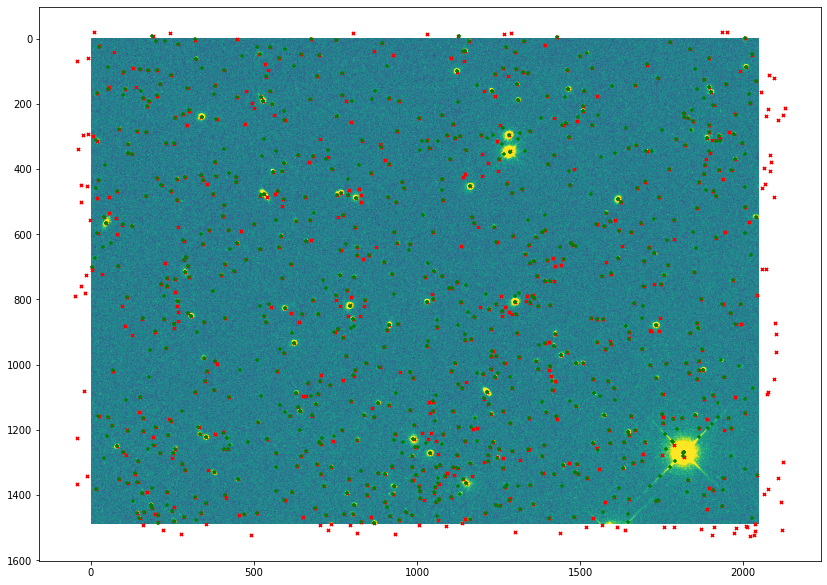

In [44]:
%matplotlib inline
plt.figure(figsize=(14,14))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(pt, pr, marker='x', color='r', s=10)
plt.scatter(pt_frame, pr_frame, marker='+', color='g', s=10) #frame detections are less accurate as expected.


## choose one chunk

In [46]:
# prepare chunk
# i, j = np.random.randint(0, 6, size=(2))
# i,j = (1,5)
clen = 200
xlim = (450, 650)
ylim = (350, 550)
print(xlim, ylim)

chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

# restrict to 200x200 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])
keep_frame = (pt_frame > xlim[0]) & (pt_frame < xlim[1]) & (pr_frame < ylim[1]) & (pr_frame > ylim[0])

# obtain star and galaxy bools for each location.
is_star = fits_file['probpsf'][:].astype(bool)
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep

(450, 650) (350, 550)


In [47]:
# move image to device
slen = 200
chunks = chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen].to(device)
print(chunks.shape)

torch.Size([1, 1, 200, 200])


[18.758669 17.499907 17.027538 16.853943 16.764172]


TypeError: unsupported format string passed to numpy.ndarray.__format__

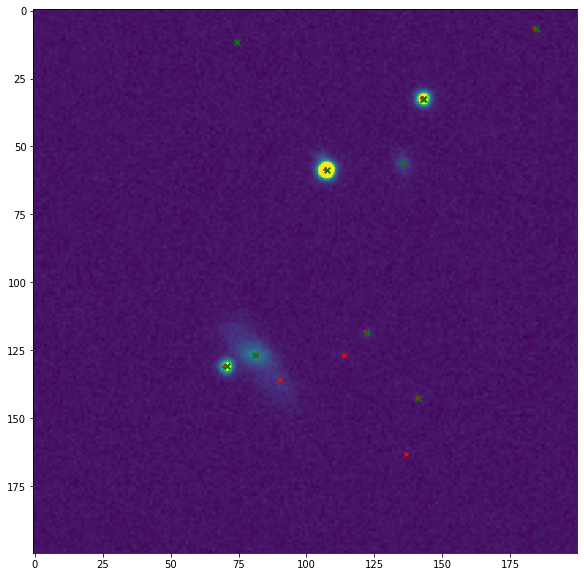

In [61]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))


p_level = 0.1
vmin = np.percentile(chunk.flatten(), p_level)
vmax = np.percentile(chunk.flatten(), 100-p_level)

# account for bias
_pt = pt - xlim[0]
_pr = pr - ylim[0]

_pt_frame = pt_frame - xlim[0]
_pr_frame = pr_frame - ylim[0]


# and show it with correct centers.
im = ax.imshow(chunk, vmin=vmin, vmax=vmax)
ax.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=20)
ax.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='r', s=30)

#mark up each detected photo object (frame) with corresponding magnitude.
ax.scatter(_pt_frame[keep_frame], _pr_frame[keep_frame], marker='x', color='g', s=30)
for i in range(len(frame_fits[keep_frame])):
    mag = frame_fits[keep_frame][i]['MODELMAG']
    print(mag)
    mag = f'{mag:.3g}'
    x,y = _pt_frame[keep_frame][i], _pr_frame[keep_frame][i]
    ax.annotate(mag, (x, y), color='g')

fig.colorbar(im, ax=ax, shrink=0.5)

## get estimate from chunk

In [15]:
# read sleep 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
image_encoder = image_encoder.eval()

In [17]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(chunks)
    sleep_net.image_decoder.background_values = (633.0, )
    
    # plot image from tile est.
    recon_image, _ = sleep_net.image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunks.shape[-1] - image_encoder.border_padding*2
    est_params = encoder.get_full_params(tile_est, _slen)

red = galaxy
blue = star


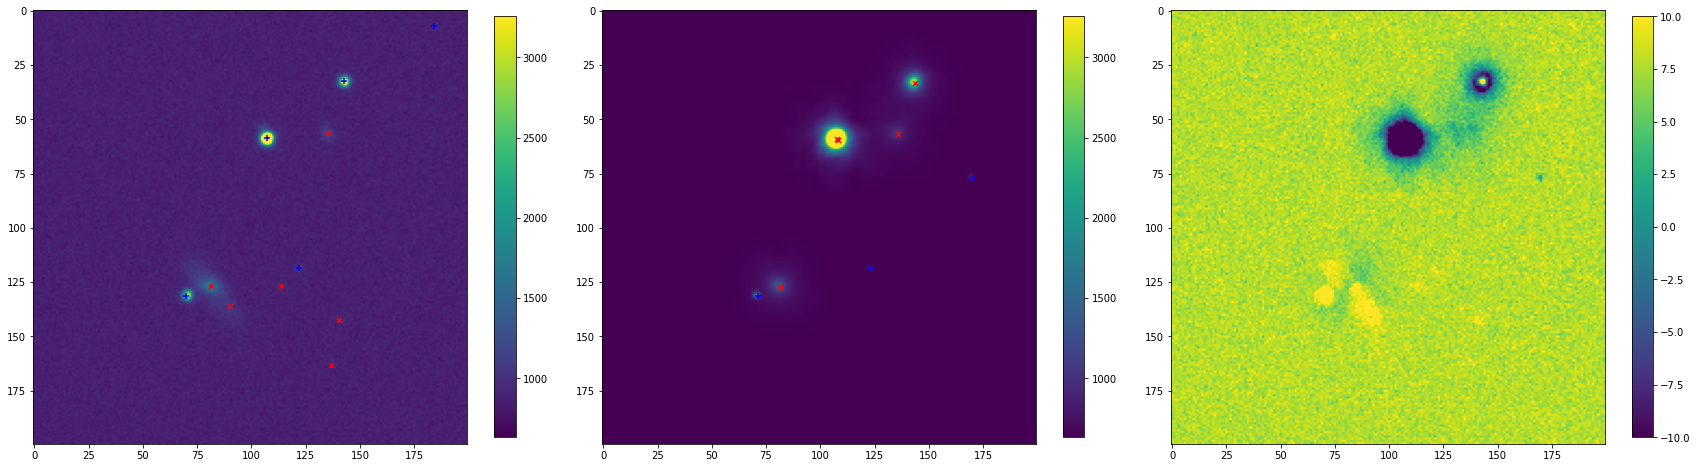

In [20]:
# plot both images side by side.
fig, axes = plt.subplots(1, 3, figsize=(24,12))
_recon_image = recon_image.detach().cpu().numpy()[0, 0]

ax1, ax2, ax3 = axes


p = 0.1
combined = np.hstack([chunk.flatten(), _recon_image.flatten()])
vmin = np.percentile(combined, p)
vmax = np.percentile(combined, 100-p)

# plot the chunk and reconstruction image side by side.
im1 = ax1.imshow(chunk, vmin=vmin, vmax=vmax)
im2 = ax2.imshow(_recon_image, vmin=vmin, vmax=vmax)
im3 = ax3.imshow( (chunk - _recon_image)/np.sqrt(chunk), vmin=-10, vmax=10)

# true image and true locations
ax1.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=20)
ax1.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='b', s=30)


# overlay the map estimate params on the full image
_locs = est_params['locs']*_slen + image_encoder.border_padding
_locs = _locs.detach().cpu().numpy()[0]
_galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
ax2.scatter(_locs[:, 1][_galaxy_bool], _locs[:, 0][_galaxy_bool], marker='x', color='r', s=25)
ax2.scatter(_locs[:, 1][~_galaxy_bool], _locs[:, 0][~_galaxy_bool], marker='+', color='b', s=30)



# colorbar
fig.colorbar(im1, ax=ax1, shrink=0.5)
fig.colorbar(im2, ax=ax2, shrink=0.5)
fig.colorbar(im3, ax=ax3, shrink=0.5)



plt.tight_layout()

print('red = galaxy')
print('blue = star')